Carga de librerías:

In [4]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import uuid

# Extracción y Transformación de información

La información proviene de: [Kaggle](https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving). La base original tiene dos carpetas con información separada, esta fue integrada previamente en dos carpetas. La siguiente sección carga las imágenes:

In [5]:
train_path = './data/training_set'
validation_path = './data/validation_set'
classes = os.listdir(train_path)

## Definición de funciones

In [6]:
def transform_image(image, target_size=(150, 150)):
    """Las imágenes original se transforman para que cada una de estas tenga el mismo número de canales y dimensiones. La imagen en img_path se convierte en una de formato RGB

    Args:
        img_path (str): Ubicación de la imagen a transformar
        target_size (tuple, optional): Dimensiones objetivo con las que se estandarizan todas las imágenes. Defaults to (150, 150).

    Returns:
        array: imagen convertida asarray y en RGB
    """
    img = image.resize(target_size)
    img_array = np.asarray(img)
    if img_array.ndim == 2:  # Grayscale image
        # Convert grayscale to RGB by stacking the same channel three times
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.ndim == 3 and img_array.shape[2] == 4:  # RGBA image
        # Convert RGBA to RGB by removing the alpha channel
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    elif img_array.ndim == 3 and img_array.shape[2] == 3:  # RGB image
        pass  # No conversion needed
    return img_array



In [7]:
def retrieve_images(path):

    corrupted_images = 0
    images_path = []
    images_type = []
    images_array = []

    for class_ in classes:
        base_path = os.path.join(path, class_)
        for file in os.listdir(base_path):
            file_path = os.path.join(base_path, file)
            try:
                with Image.open(file_path) as image:
                    images_type.append(class_)
                    images_path.append(file_path)
                    image_matrix = transform_image(image)
                    images_array.append(image_matrix)

            except Image.UnidentifiedImageError:
                corrupted_images += 1
    print(f'Se procesaron {len(images_array)} imágenes correctamente.')
    print(f'{corrupted_images} no pudieron ser procesadas por errores en formato.')
    images_df = pd.DataFrame({'matriz': images_array, 'clase': images_type, 'ruta': images_path})
    return images_df

In [8]:
df = retrieve_images(train_path)

Se procesaron 8188 imágenes correctamente.
108 no pudieron ser procesadas por errores en formato.


# Exploración de datos

Se visualiza una de de las imágenes importadas:

Clase: iconography
Ruta: ./data/training_set\iconography\187 18.59.20.jpg


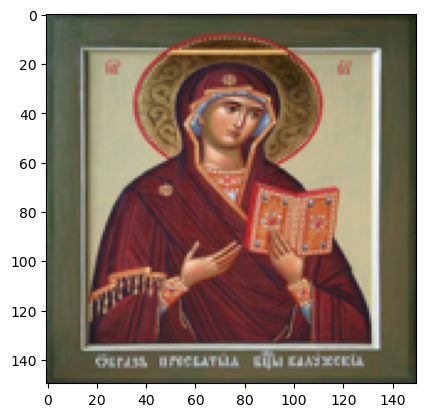

In [10]:
test_image = 2000
print(f'Clase: {df["clase"].iloc[test_image]}')
print(f'Ruta: {df["ruta"].iloc[test_image]}')
plt.imshow(df['matriz'].iloc[test_image]);


Ejemplo del canal rojo:

In [11]:
img_example = df['matriz'].iloc[test_image]

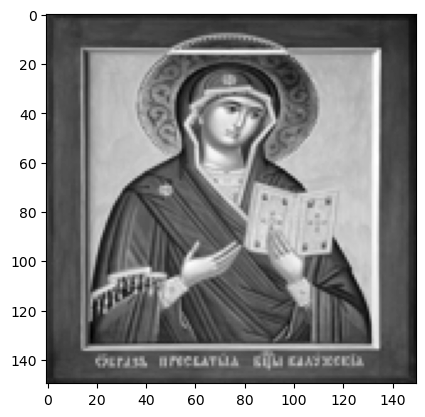

In [16]:
plt.imshow(img_example[:,:,0], cmap='gray');

Ejemplo del canal verde

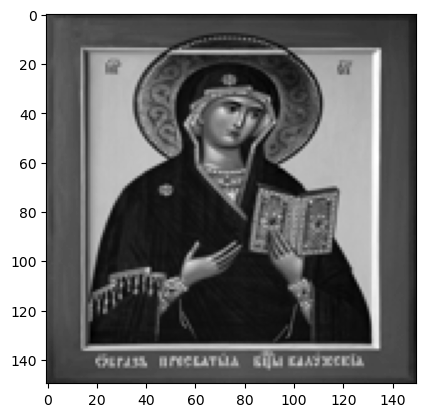

In [17]:
plt.imshow(img_example[:,:,1], cmap='gray');

Ejemplo del canal azul:

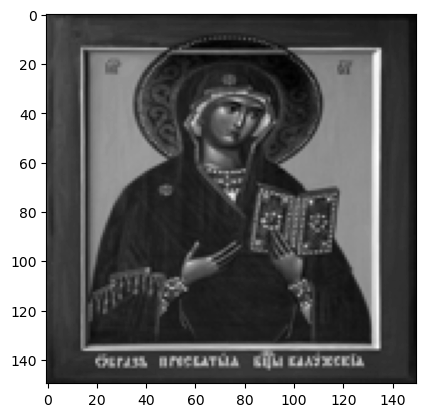

In [18]:
plt.imshow(img_example[:,:,2], cmap='gray');

Nota: El borde de las imágenes que no se lograron ajustar a las dimensiones se entienden como blancos en la imagen.

In [19]:
img_example.shape

(150, 150, 3)

## Descripción de la base

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   matriz  8188 non-null   object
 1   clase   8188 non-null   object
 2   ruta    8188 non-null   object
dtypes: object(3)
memory usage: 192.0+ KB


Text(0, 0.5, 'frecuencia')

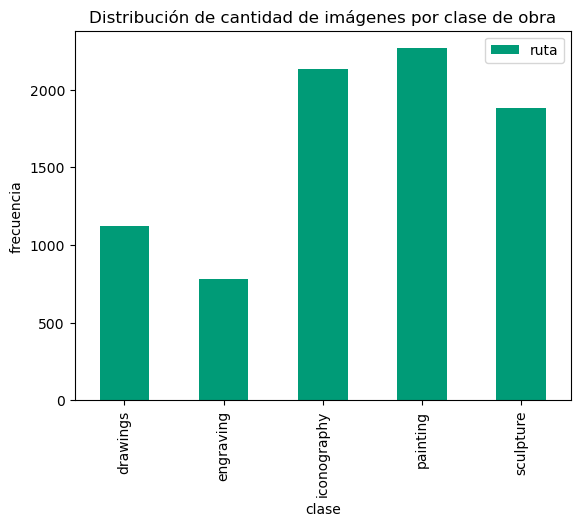

In [22]:
type_freq = df[['ruta', 'clase']].groupby(['clase']).count()
type_freq.plot.bar(column='clase', color='#009B77')
plt.title('Distribución de cantidad de imágenes por clase de obra')
plt.ylabel('frecuencia')

Histograma de colores

In [69]:
colors = ('b', 'g', 'r')

def crear_histograma(img_array):
    histograma = []
    for i, _ in enumerate(colors):
        hist = cv2.calcHist([img_array], [i], None, [256], [0,256])
        histograma.append(hist)
    return histograma
    
def mostrar_histograma(hist_array):
    for i, col in enumerate(colors):
        plt.plot(hist_array[i], color=col)
    plt.legend(colors)
    plt.xlabel('Nivel de intensidad')
    plt.ylabel('Cantidad de pixeles')
    return


def array_promedio(lista):
    stacked_arrays = np.array(lista)
    mean_array = np.mean(stacked_arrays, axis=0)
    return mean_array

Ejemplo de histograma de colores para imagen ejemplo:

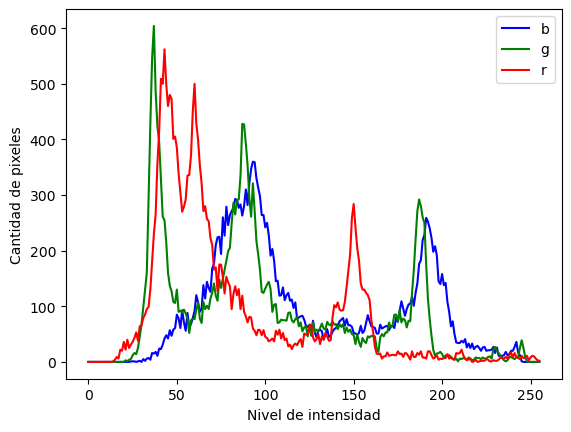

In [70]:
hist_ej = crear_histograma(df['matriz'].iloc[test_image])
mostrar_histograma(hist_ej)

Para poder describir de manera grupal los histogramas de las bases de datos, se calcula el histograma con los resultados promedio de todos los canales para todas las imagenes.

In [72]:
histogramas = []
for array_ in df['matriz']:
    histogramas.append(crear_histograma(array_))
mean_array = array_promedio(histogramas)

In [73]:
mean_array.shape

(3, 256, 1)

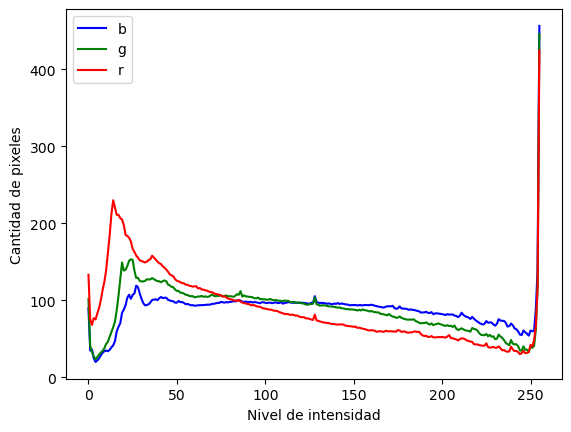

In [74]:
mostrar_histograma(mean_array)

Este análisis solo nos muestra que existe en promedio una alta cantidad de áreas brillantes en la totalidad de las fotos. Sin embargo, se quiere revisar las diferencias que existen entre los tipos de histograma para cada uno de los tipos de obras de arte.

## Análisis de histograma promedio por tipo de imagen

Ejemplo de histograma de colores para imagen ejemplo:

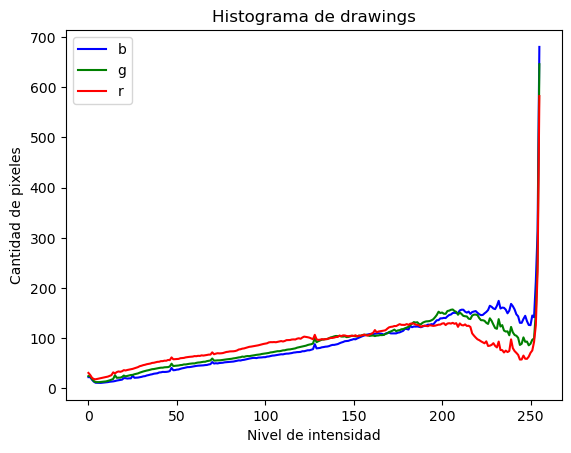

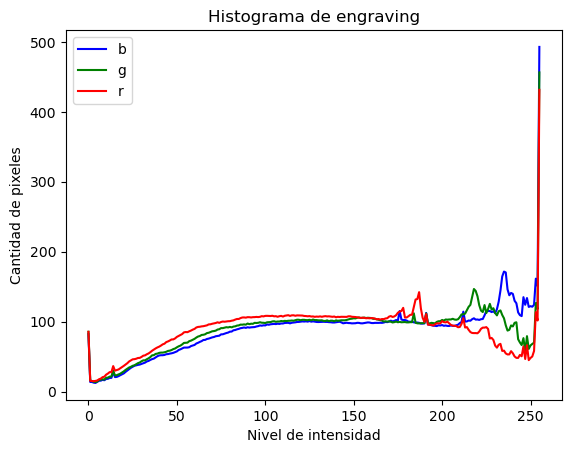

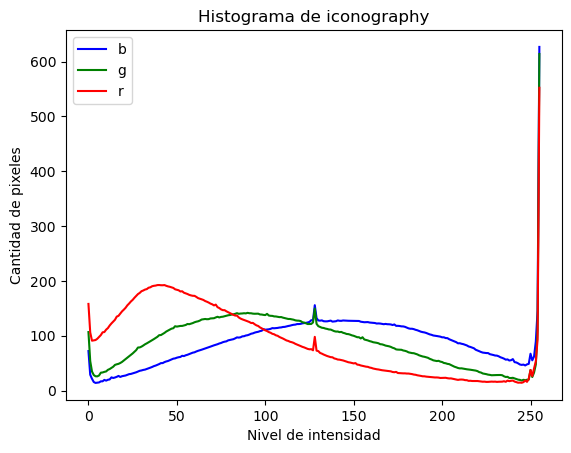

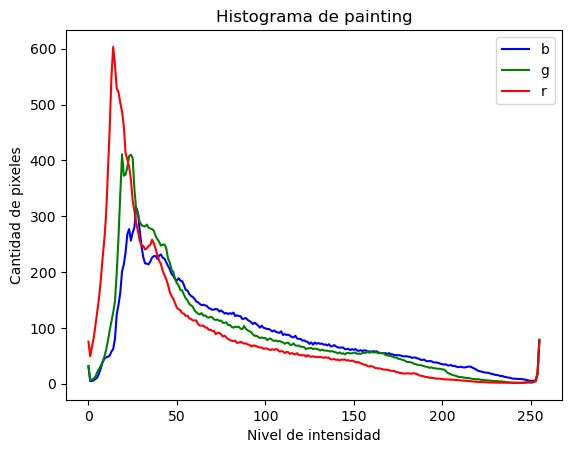

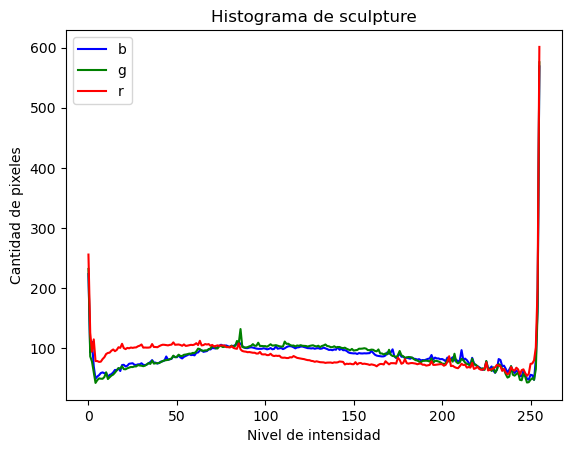

In [82]:
grouped_df = df.groupby('clase')

for clase in grouped_df:
    histogramas_clase = []
    for array_ in clase[1]['matriz']:
        histogramas_clase.append(crear_histograma(array_))
    mean_group_array = array_promedio(histogramas_clase)
    plt.figure()
    mostrar_histograma(mean_group_array)
    plt.title(f'Histograma de {clase[0]}')
    
    
    